In [1]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mode

In [2]:
# Read in file 
data = pd.read_csv("../data/curated/outliers_removed.csv")

In [3]:
# Change Weekly Rental Price columns to first column
price = data["Weekly Rental Price"]
data = data.drop(["Weekly Rental Price"], axis = 1)
data.insert(0, "Weekly Rental Price", price)
data = data.drop(labels = ['Unnamed: 0'],axis = 1) 
data = data.fillna(40000)

In [4]:
# Filter dirty data
data = data[(data['Baths'] > 0) & (data['Bedrooms'] > 0)]

In [5]:
# Take out postcode column
postcode = data["Postcode"]

In [6]:
# Apply one hot encoding on Postcode
new_data = pd.get_dummies(data, columns = ['Postcode'])

In [7]:
# Split features and predict results
y = new_data['Weekly Rental Price']
x = new_data.iloc[:,1:]

In [8]:
# Processed X into value between 0 and 1
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(x)

In [9]:
# Split the data set into training/testing and validation sets
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [13]:
# Create model and train the model
model = Sequential([
    Dense(32, activation='relu', kernel_regularizer = regularizers.l2(0.1), input_shape=(426,)),
    Dense(32, activation='relu', kernel_regularizer = regularizers.l2(0.1)),
    Dense(32, activation='relu', kernel_regularizer = regularizers.l2(0.1)),
    Dense(32, activation='relu', kernel_regularizer = regularizers.l2(0.1)),
    Dense(32, activation='relu', kernel_regularizer = regularizers.l2(0.1)),
    Dense(1, activation='linear', kernel_regularizer = regularizers.l2(0.1))])

model.compile(optimizer = "adam",
              loss='mean_squared_error',
              metrics=['mae'])

hist = model.fit(X_train, Y_train,
          batch_size=32, epochs=100,
          validation_data=(X_val, Y_val))

Epoch 1/100
252/252 [==============================] - 3s 5ms/step - loss: 149398.6250 - mae: 267.1720 - val_loss: 76914.7500 - val_mae: 138.0325
Epoch 2/100
252/252 [==============================] - 1s 5ms/step - loss: 47846.7891 - mae: 117.9146 - val_loss: 62415.0469 - val_mae: 120.7006
Epoch 3/100
252/252 [==============================] - 1s 4ms/step - loss: 39851.3750 - mae: 107.4019 - val_loss: 56319.3164 - val_mae: 115.2173
Epoch 4/100
252/252 [==============================] - 1s 5ms/step - loss: 37215.4648 - mae: 105.1753 - val_loss: 55020.8086 - val_mae: 117.0557
Epoch 5/100
252/252 [==============================] - 1s 4ms/step - loss: 35723.8125 - mae: 101.8829 - val_loss: 57733.5703 - val_mae: 134.8230
Epoch 6/100
252/252 [==============================] - 2s 6ms/step - loss: 34820.5742 - mae: 100.9085 - val_loss: 52126.0898 - val_mae: 108.9621
Epoch 7/100
252/252 [==============================] - 1s 4ms/step - loss: 33731.5625 - mae: 98.3140 - val_loss: 51607.0781 - val

54/54 [==============================] - 0s 2ms/step - loss: 34796.9688 - mae: 93.8970


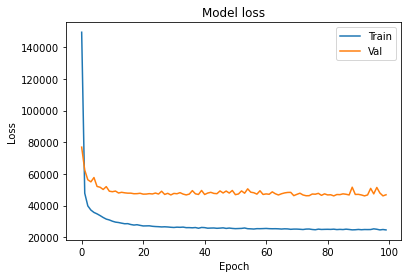

In [14]:
# Do the model evaluation
model.evaluate(X_test, Y_test)[1]

# Plot the model performance
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

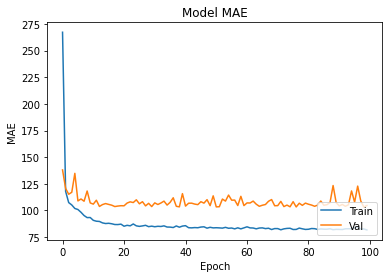

In [15]:
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [16]:
# Add postcode back to data
post_data = new_data.iloc[:,1:]
post_data.insert(0, "Postcode", postcode)

In [17]:
# Read in income data
pop = pd.read_csv("../data/curated/predict_income.csv")

In [18]:
# Update population in 2023/2024/2025
pop_2023 = pop[['Postcode','2023']]
pop_2024 = pop[['Postcode','2024']]
pop_2025 = pop[['Postcode','2025']]

In [19]:
# Create feature data for 2023
pop_2023 = pd.merge(pop_2023, post_data, how = 'right', on = ['Postcode'])
pop_2023 = pop_2023.drop(labels = ['Income'],axis = 1) 
pop_2023 = pop_2023.iloc[:,1:]
income_2023 = pop_2023["2023"]
pop_2023 = pop_2023.drop(labels = ['2023'],axis = 1) 
pop_2023.insert(4, 'Income', income_2023)
min_max_scaler = preprocessing.MinMaxScaler()
pop_2023 = min_max_scaler.fit_transform(pop_2023)

In [20]:
# Prediction of 2023
pred_2023 = model.predict(pop_2023)
data.insert(7, 'Pred_2023', pred_2023)
data

360/360 [==============================] - 1s 1ms/step


,Weekly Rental Price,Postcode,Baths,Bedrooms,Parking,Count_Shopping_Center,Income,Pred_2023
0,440.0,3000,1,1,1,18.0,38674.046186,506.687469
1,650.0,3000,2,2,1,18.0,38674.046186,847.437073
2,440.0,3000,1,1,0,18.0,38674.046186,479.787567
3,320.0,3000,1,1,0,18.0,38674.046186,479.787567
4,700.0,3000,2,2,0,18.0,38674.046186,708.909180
...,...,...,...,...,...,...,...,...
11491,600.0,3996,2,3,2,0.0,52284.246429,455.864227
11492,550.0,3996,2,4,0,0.0,52284.246429,468.830780
11493,420.0,3996,1,2,0,0.0,52284.246429,344.079926
11494,370.0,3996,1,2,1,0.0,52284.246429,341.547028


In [21]:
# Create feature data for 2024
pop_2024 = pd.merge(pop_2024, post_data, how = 'right', on = ['Postcode'])
pop_2024 = pop_2024.drop(labels = ['Income'],axis = 1) 
pop_2024 = pop_2024.iloc[:,1:]
income_2024 = pop_2024["2024"]
pop_2024 = pop_2024.drop(labels = ['2024'],axis = 1) 
pop_2024.insert(4, 'Income', income_2024)
min_max_scaler = preprocessing.MinMaxScaler()
pop_2024 = min_max_scaler.fit_transform(pop_2024)

In [22]:
# Prediction of 2024
pred_2024 = model.predict(pop_2024)
data.insert(8, 'Pred_2024', pred_2024)
data

360/360 [==============================] - 0s 1ms/step


,Weekly Rental Price,Postcode,Baths,Bedrooms,Parking,Count_Shopping_Center,Income,Pred_2023,Pred_2024
0,440.0,3000,1,1,1,18.0,38674.046186,506.687469,505.008575
1,650.0,3000,2,2,1,18.0,38674.046186,847.437073,867.947815
2,440.0,3000,1,1,0,18.0,38674.046186,479.787567,478.108734
3,320.0,3000,1,1,0,18.0,38674.046186,479.787567,478.108734
4,700.0,3000,2,2,0,18.0,38674.046186,708.909180,714.565247
...,...,...,...,...,...,...,...,...,...
11491,600.0,3996,2,3,2,0.0,52284.246429,455.864227,451.174957
11492,550.0,3996,2,4,0,0.0,52284.246429,468.830780,457.333221
11493,420.0,3996,1,2,0,0.0,52284.246429,344.079926,337.950195
11494,370.0,3996,1,2,1,0.0,52284.246429,341.547028,335.431885


In [23]:
# Create feature data for 2025
pop_2025 = pd.merge(pop_2025, post_data, how = 'right', on = ['Postcode'])
pop_2025 = pop_2025.drop(labels = ['Income'],axis = 1) 
pop_2025 = pop_2025.iloc[:,1:]
income_2025 = pop_2025["2025"]
pop_2025 = pop_2025.drop(labels = ['2025'],axis = 1) 
pop_2025.insert(4, 'Income', income_2025)
min_max_scaler = preprocessing.MinMaxScaler()
pop_2025 = min_max_scaler.fit_transform(pop_2025)

In [24]:
# Prediction of 2025
pred_2025 = model.predict(pop_2025)
data.insert(9, 'Pred_2025', pred_2025)
data

360/360 [==============================] - 0s 1ms/step


,Weekly Rental Price,Postcode,Baths,Bedrooms,Parking,Count_Shopping_Center,Income,Pred_2023,Pred_2024,Pred_2025
0,440.0,3000,1,1,1,18.0,38674.046186,506.687469,505.008575,504.208374
1,650.0,3000,2,2,1,18.0,38674.046186,847.437073,867.947815,886.158691
2,440.0,3000,1,1,0,18.0,38674.046186,479.787567,478.108734,476.618134
3,320.0,3000,1,1,0,18.0,38674.046186,479.787567,478.108734,476.618134
4,700.0,3000,2,2,0,18.0,38674.046186,708.909180,714.565247,723.837158
...,...,...,...,...,...,...,...,...,...,...
11491,600.0,3996,2,3,2,0.0,52284.246429,455.864227,451.174957,447.412994
11492,550.0,3996,2,4,0,0.0,52284.246429,468.830780,457.333221,449.442413
11493,420.0,3996,1,2,0,0.0,52284.246429,344.079926,337.950195,333.391235
11494,370.0,3996,1,2,1,0.0,52284.246429,341.547028,335.431885,331.712555


In [25]:
# Calculate growth rate
data['rate_2023'] = (data['Pred_2023'] - data['Weekly Rental Price']) / data['Weekly Rental Price']
data['rate_2024'] = (data['Pred_2024'] - data['Pred_2023']) / data['Pred_2023']
data['rate_2025'] = (data['Pred_2025'] - data['Pred_2024']) / data['Pred_2024']
data = data[["Postcode", "Weekly Rental Price", "Pred_2023", "Pred_2024", "Pred_2025", "rate_2023", "rate_2024", "rate_2025"]]

In [26]:
# Group by the data by the postcode
data = data.groupby(by = ['Postcode']).mean()
data = data.sort_values(by = ['rate_2023'], ascending = False)
data = data.head(10)
data.to_csv("../data/curated/NNpredi.csv")